# Inference of parameters with latent variables (SEAI5R model)
In this notebook, we consider the SEAI5R model with various stages of infection: exposed, activated, asymptomatic infected, symptomatic infected, hospitalised, critial and mortality. We are trying to infer the following parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)

when given data of classes Is, Ih, Ic, Im from a generated trajectory.

In [6]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [8]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([10, 10])
A0  = np.array([10, 10])
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAI5R_latent_traj.npy', data_array)

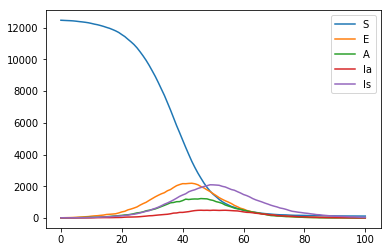

In [9]:
# plot the stochastic solution 
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

## 2) Inference
We take the first $30$ data points of the $I_\mathrm{s}, I_\mathrm{h}, I_\mathrm{c}, I_\mathrm{m}$ trajectory and use it to infer the parameters of the model.

In [10]:
# load the data and rescale to intensive variables 
Tf_inference = 30 
Nf_inference = Tf_inference + 1 

x = np.load('SEAI5R_latent_traj.npy').astype('float')
x = x[:Nf_inference,:8*M]/N
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2524.1051544897064
0.8233017921447754


In [11]:
eps = 1e-4 

alpha_g = 0.25          
alpha_std = 0.1
alpha_b = (0.05, 0.5)

beta_g  = 0.06         
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.21 
gE_std = 0.05
gE_b = (0.1, 0.3)

gA_g    = 0.35 
gA_std = 0.05 
gA_b = (0.2, 0.5) 
   

E0_g = (E0+3)/N
E0_std = E0_g
E0_b = [[0.1/N, 100/N]]*M 

A0_g  = (A0+3)/N
A0_std = A0_g
A0_b = [[0.1/N, 100/N]]*M

Ia0_g = (Ia0+0.2)/N 
Ia0_std = [5/N]*M
Ia0_b = [(0.1/N, 100/N)]*M

Is0_g = (Is0+0.1)/N 
Is0_std = [5/N]*M  
Is0_b = [(0.1/N, 100/N)]*M

Ih0_g = (Ih0+0.1)/N 
Ih0_std = [5/N]*M 
Ih0_b = [(0.1/N, 100/N)]*M

Ic0_g = (Ic0+0.1)/N 
Ic0_std = [5/N]*M 
Ic0_b = [(0.1/N, 100/N)]*M

Im0_g = (Im0+0.1)/N 
Im0_std = [5/N]*M 
Im0_b = [(0.1/N, 100/N)]*M

S0_g = (S0-10)/N 
S0_std = E0_std*4 
S0_b = [(1/N, f) for f in fi]



# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *S0_b, *E0_b, *A0_b, *Ia0_b, *Is0_b, *Ih0_b, *Ic0_b, *Im0_b])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                   *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S0_std, *E0_std, *A0_std, *Ia0_std, *Is0_std, *Ih0_std, *Ic0_std, *Im0_std])
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=30, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 22 (seed=2377470565, Tue May 12 18:45:51 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.777711640425611e+03 1.0e+00 9.48e-01  9e-04  1e-01 0:10.9
    2     32 -2.484375658755657e+03 1.1e+00 9.35e-01  9e-04  9e-02 0:19.6
    3     48 -1.700603637078662e+03 1.1e+00 9.71e-01  1e-03  1e-01 0:28.0
    4     64 -2.470920935849455e+03 1.2e+00 9.64e-01  9e-04  1e-01 0:34.4
    5     80 -2.424546099663620e+03 1.3e+00 9.99e-01  1e-03  1e-01 0:43.0
    6     96 -2.403491765179361e+03 1.3e+00 1.02e+00  1e-03  1e-01 0:50.5
    7    112 -1.941362235175533e+03 1.3e+00 9.83e-01  9e-04  1e-01 0:59.2
    8    128 -2.460666541818803e+03 1.4e+00 9.74e-01  9e-04  1e-01 1:06.9
    9    144 -2.465645562089970e+03 1.4e+00 9.36e-01  9e-04  1e-01 1:15.3
   11    176 -2.425431054500677e+03 1.4e+00 9.39e-01  9e-04  1e-01 1:30.0
   13    208 -2.390795367382314e+03 1.4e+00 9.72e-01  9e-04  

In [13]:
# save the parameters 
np.save('SEAI5R_latent_param.npy', params)

In [14]:
print('True parameters')
print(parameters)

params = np.load('SEAI5R_latent_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0)
print('\n Inferred initial conditons: ') 
print((params[6:]*N).astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'gE': 0.2, 'gA': 0.3333333333333333, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}

 Best estimates
{'alpha': 0.38538913452023416, 'beta': 0.024094904542416227, 'gIa': 0.07178489787962614, 'gIs': 0.17993147301995116, 'gE': 0.16220806120612163, 'gA': 0.2962051102984762, 'gIh': 0.07142857142857142, 'gIc': 0.07142857142857142, 'fsa': 0.8, 'fh': 0.1, 'sa': 0, 'hh': array([0.1, 0.1]), 'cc': array([0.05, 0.05]), 'mm': array([0.4, 0.4])}

 True initial conditions: 
[12460. 37460.] [10 10] [10 10] [10 10] [10 10] [0. 0.] [0. 0.] [0. 0.]

 Inferred initial conditons: 
[12450 37459    19    13    24    17    13    12     6    11     0     0
     0     0     0     0]


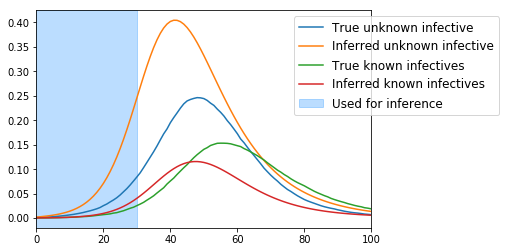

In [15]:
# Compare inferred trajectories to true trajectories 
x0 = params[6:]
det_model = pyross.deterministic.SEAI5R(best_estimates, int(M), fi)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAI5R_latent_traj.npy').astype('float')[:, :8*M]/N

plt.plot(np.sum(x[:,M:4*M], axis=1), label='True unknown infective')
plt.plot(np.sum(x_det[:,M:4*M], axis=1), label='Inferred unknown infective')
plt.plot(np.sum(x[:,4*M:], axis=1), label='True known infectives')
plt.plot(np.sum(x_det[:, 4*M:], axis=1), label='Inferred known infectives')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()